In [2]:
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, CustomJS, Slider
from bokeh.plotting import Figure, output_file, show, output_notebook
import bokeh.models as bmo
from bokeh.palettes import d3

import numpy as np

# output_notebook()
# output_file("../_includes/finite_mixture_model.html")

from bokeh.transform import linear_cmap, factor_cmap
N= 5000
maxK = 100
K = [10]*N
alpha = [1.]*N
pi = np.random.dirichlet(alpha[0]*np.ones(K[0]))
means = np.random.randn(K[0], 2)
z = np.random.choice(range(K[0]), p=pi, size=N)
data = means[z,:]
data += np.random.randn(*data.shape)*0.15
x = data[:,0]
y = data[:,1]
z = (z*int(maxK/K[0]))


source = ColumnDataSource(data=dict(x=x, y=y, z=z, K=K, alpha=alpha))

plot = Figure(width=800, height=500)
plot.scatter('x', 'y', source=source, color=linear_cmap('z', "Turbo256", 0, 100), alpha=0.5)

code_rand_library = """

    function rnormal() {
            var u = 0, v = 0;
            while(u === 0) u = Math.random(); 
            while(v === 0) v = Math.random();
            return Math.sqrt( -2.0 * Math.log( u ) ) * Math.cos( 2.0 * Math.PI * v );
        }

    function sum(nums) {
      var accumulator = 0;
      for (var i = 0, l = nums.length; i < l; i++)
        accumulator += nums[i];
      return accumulator;
    }

    function rbeta(alpha, beta) {
      var alpha_gamma = rgamma(alpha, 1);
      return alpha_gamma / (alpha_gamma + rgamma(beta, 1));
    }

    var SG_MAGICCONST = 1 + Math.log(4.5);
    var LOG4 = Math.log(4.0);

    function rgamma(alpha, beta) {
      if (alpha > 1) {
        var ainv = Math.sqrt(2.0 * alpha - 1.0);
        var bbb = alpha - LOG4;
        var ccc = alpha + ainv;

        while (true) {
          var u1 = Math.random();
          if (!((1e-7 < u1) && (u1 < 0.9999999))) {
            continue;
          }
          var u2 = 1.0 - Math.random();
          var v = Math.log(u1/(1.0-u1))/ainv;
          var x = alpha*Math.exp(v);
          var z = u1*u1*u2;
          var r = bbb+ccc*v-x;
          if (r + SG_MAGICCONST - 4.5*z >= 0.0 || r >= Math.log(z)) {
            return x * beta;
          }
        }
      }
      else if (alpha == 1.0) {
        var u = Math.random();
        while (u <= 1e-7) {
          u = Math.random();
        }
        return -Math.log(u) * beta;
      }
      else { 
        while (true) {
          var u3 = Math.random();
          var b = (Math.E + alpha)/Math.E;
          var p = b*u3;
          if (p <= 1.0) {
            var x = Math.pow(p, (1.0/alpha));
          }
          else {
            var x = -Math.log((b-p)/alpha);
          }
          var u4 = Math.random();
          if (p > 1.0) {
            if (u4 <= Math.pow(x, (alpha - 1.0))) {
              break;
            }
          }
          else if (u4 <= Math.exp(-x)) {
            break;
          }
        }
        return x * beta;
      }
    }
    
    function rdirichlet(alpha) {
      var gammas = [];
      for (var i = 0, l = alpha.length; i < l; i++)
        gammas.push(rgamma(alpha[i], 1));
        
      var accum = sum(gammas)
      
      for (var i = 0, l = gammas.length; i < l; i++)
        gammas[i] = gammas[i]/accum
      return gammas
    }
    
    function rcategorical(pi){
      var u = Math.random();
      var k = 0
      var cum = pi[0]
      for (var i = 1, l = pi.length; i < l; i++)
        if (u <= cum){
            break;
        }
        else{
            cum = cum + pi[i]
            k = k+1
        }
      return k
    }
      
    """

callback = CustomJS(args=dict(source=source), code=code_rand_library + """
    const data = source.data;
    const K = cb_obj.value
    const alpha = data["alpha"][0]
    const x = data['x']
    const y = data['y']
    const z = data['z']
    const oldK = data["K"]
    oldK[0] = K
    
    var means_x = []
    var means_y = []
    var alphas = []
    
    for (let i = 0; i < K; i++) {
        means_x.push(rnormal())
        means_y.push(rnormal())
        alphas.push(alpha)
    }
    
    var pi = rdirichlet(alphas)
    var new_x = []
    var new_y = []
    var new_z = []
    var group = 0
    
    for (let i = 0; i < x.length; i++) {
        group = rcategorical(pi)
        new_x.push(means_x[group] + rnormal()*0.1)
        new_y.push(means_y[group] + rnormal()*0.1)
        new_z.push(group)
    }
    
    for (let i = 0; i < x.length; i++) {
        x[i] = new_x[i]
        y[i] = new_y[i]
        z[i] = new_z[i]*parseInt(100/K)
    }
    

    source.change.emit();
""")

callback2 = CustomJS(args=dict(source=source), code=code_rand_library + """
    const data = source.data;
    const alpha = cb_obj.value
    const x = data['x']
    const y = data['y']
    const z = data['z']
    const K = data["K"][0]
    const oldAlpha = data["alpha"]
    oldAlpha[0] = alpha

    var means_x = []
    var means_y = []
    var alphas = []
    
    for (let i = 0; i < K; i++) {
        means_x.push(rnormal())
        means_y.push(rnormal())
        alphas.push(alpha)
    }
    
    var pi = rdirichlet(alphas)
    var new_x = []
    var new_y = []
    var new_z = []
    var group = 0
    
    for (let i = 0; i < x.length; i++) {
        group = rcategorical(pi)
        new_x.push(means_x[group] + rnormal()*0.1)
        new_y.push(means_y[group] + rnormal()*0.1)
        new_z.push(group)
    }
    
    for (let i = 0; i < x.length; i++) {
        x[i] = new_x[i]
        y[i] = new_y[i]
        z[i] = new_z[i]*parseInt(100/K)
    }
    

    source.change.emit();
""")

slider = Slider(start=1, end=100, value=10, step=1, title="K")
slider.js_on_change('value', callback)

slider2 = Slider(start=0.01, end=5, value=1, step=0.01, title="alpha")
slider2.js_on_change('value', callback2)

layout = column(slider,slider2, plot)


show(layout)

In [2]:
code_rand_library = """

    function rnormal() {
            var u = 0, v = 0;
            while(u === 0) u = Math.random(); 
            while(v === 0) v = Math.random();
            return Math.sqrt( -2.0 * Math.log( u ) ) * Math.cos( 2.0 * Math.PI * v );
        }

    function sum(nums) {
      var accumulator = 0;
      for (var i = 0, l = nums.length; i < l; i++)
        accumulator += nums[i];
      return accumulator;
    }

    function rbeta(alpha, beta) {
      var alpha_gamma = rgamma(alpha, 1);
      return alpha_gamma / (alpha_gamma + rgamma(beta, 1));
    }

    var SG_MAGICCONST = 1 + Math.log(4.5);
    var LOG4 = Math.log(4.0);

    function rgamma(alpha, beta) {
      if (alpha > 1) {
        var ainv = Math.sqrt(2.0 * alpha - 1.0);
        var bbb = alpha - LOG4;
        var ccc = alpha + ainv;

        while (true) {
          var u1 = Math.random();
          if (!((1e-7 < u1) && (u1 < 0.9999999))) {
            continue;
          }
          var u2 = 1.0 - Math.random();
          var v = Math.log(u1/(1.0-u1))/ainv;
          var x = alpha*Math.exp(v);
          var z = u1*u1*u2;
          var r = bbb+ccc*v-x;
          if (r + SG_MAGICCONST - 4.5*z >= 0.0 || r >= Math.log(z)) {
            return x * beta;
          }
        }
      }
      else if (alpha == 1.0) {
        var u = Math.random();
        while (u <= 1e-7) {
          u = Math.random();
        }
        return -Math.log(u) * beta;
      }
      else { 
        while (true) {
          var u3 = Math.random();
          var b = (Math.E + alpha)/Math.E;
          var p = b*u3;
          if (p <= 1.0) {
            var x = Math.pow(p, (1.0/alpha));
          }
          else {
            var x = -Math.log((b-p)/alpha);
          }
          var u4 = Math.random();
          if (p > 1.0) {
            if (u4 <= Math.pow(x, (alpha - 1.0))) {
              break;
            }
          }
          else if (u4 <= Math.exp(-x)) {
            break;
          }
        }
        return x * beta;
      }
    }
    
    function rdirichlet(alpha) {
      var gammas = [];
      for (var i = 0, l = alpha.length; i < l; i++)
        gammas.push(rgamma(alpha[i], 1));
        
      var accum = sum(gammas)
      
      for (var i = 0, l = gammas.length; i < l; i++)
        gammas[i] = gammas[i]/accum
      return gammas
    }
    
    function rcategorical(pi){
      var u = Math.random();
      var k = 0
      var cum = pi[0]
      for (var i = 1, l = pi.length; i < l; i++)
        if (u <= cum){
            break;
        }
        else{
            cum = cum + pi[i]
            k = k+1
        }
      return k
    }
      
    """

In [5]:
from bokeh.models import Button, Toggle

output_notebook()
output_file("../_includes/rate_of_clusters.html")


K = 1000
alpha = 1.
pi = np.random.dirichlet(alpha*np.ones(K))
z = np.random.choice(range(K), p=pi, size=N)

x = [0]
y = [0]
source = ColumnDataSource(data=dict(x=x,y=y))



plot = Figure(width=800, height=500)
plot.scatter('x', 'y', source=source)
plot.xaxis.axis_label="Datapoints"
plot.x_range.start=0
plot.y_range.start=0

callback = CustomJS(args=dict(source=source, p=plot), code=code_rand_library + """
    const data = source.data;
    var x = data['x']
    var y = data['y']

    var K = 1000
    var alpha = 0.1
    var alphas = []
    
    for (let i = 0; i < K; i++) {
        alphas.push(alpha)
    }

    var pi = rdirichlet(alphas)
    var seen_cluster = []
    var i = 0
    var z = 0

    function update() {
    
        if (!(cb_obj.active)){
            return;
        }
        
        i = i + 1;
        z = rcategorical(pi);
        
        if (seen_cluster.includes(z)){
            x.push(i);
            y.push(seen_cluster.indexOf(z));
        }
        else{
            seen_cluster.push(z)
            x.push(i);
            y.push(seen_cluster.indexOf(z));
        }  
        source.change.emit();
    }
    
    if (x.length == 1){
        var looop = setInterval(update, 100);
    }

    if(cb_obj.active == false){
        cb_obj.label = '► Play';
    }
    else {
        cb_obj.label = '❚❚ Pause';

    }
    
""")

plot.yaxis.axis_label="Assignt cluster in order of appearence"

button = Toggle(label='► Play', button_type='success', active=False, width=320)
button.js_on_change("active", callback)

layout = column(button, plot)
show(layout)


Loading BokehJS ...

RuntimeError: Models must be owned by only a single document, ColumnDataSource(id='1002', ...) is already in a doc

In [3]:
# from bokeh.models import Button, Toggle

# output_notebook()
# output_file("../_includes/rate_of_clusters_infinite.html")


# K = 1000
# alpha = 1.
# pi = np.random.dirichlet(alpha*np.ones(K))
# z = np.random.choice(range(K), p=pi, size=N)

# x = [0]
# y = [0]
# source = ColumnDataSource(data=dict(x=x,y=y))



# plot = Figure(width=800, height=500)
# plot.scatter('x', 'y', source=source)
# plot.xaxis.axis_label="Datapoints"
# plot.x_range.start=0
# plot.y_range.start=0

# callback = CustomJS(args=dict(source=source, p=plot), code=code_rand_library + """
#     const data = source.data;
#     var x = data['x']
#     var y = data['y']

#     var K = 1000
#     var alpha = 0.1
#     var alphas = []
    
#     for (let i = 0; i < K; i++) {
#         alphas.push(alpha)
#     }

#     var pi = rdirichlet(alphas)
#     var seen_cluster = []
#     var i = 0
#     var z = 0

#     function update() {
    
#         if (!(cb_obj.active)){
#             return;
#         }
        
#         i = i + 1;
#         z = rcategorical(pi);
        
#         if (seen_cluster.includes(z)){
#             x.push(i);
#             y.push(seen_cluster.indexOf(z));
#         }
#         else{
#             seen_cluster.push(z)
#             x.push(i);
#             y.push(seen_cluster.indexOf(z));
#         }  
#         source.change.emit();
#     }
    
#     if (x.length == 1){
#         var looop = setInterval(update, 100);
#     }

#     if(cb_obj.active == false){
#         cb_obj.label = '► Play';
#     }
#     else {
#         cb_obj.label = '❚❚ Pause';

#     }
    
# """)

# plot.yaxis.axis_label="Assignt cluster in order of appearence"

# button = Toggle(label='► Play', button_type='success', active=False, width=320)
# button.js_on_change("active", callback)

# layout = column(button, plot)
# show(layout)


Loading BokehJS ...

In [6]:
from bokeh.models import Button, Toggle

output_notebook()
output_file("../_includes/rate_of_clusters_infinite_DP.html")


K = 1000
alpha = 1.

x = [0]
y = [0]
source = ColumnDataSource(data=dict(x=x,y=y))



plot = Figure(width=800, height=500)
plot.scatter('x', 'y', source=source)
plot.xaxis.axis_label="Datapoints"
plot.x_range.start=0
plot.y_range.start=0

callback = CustomJS(args=dict(source=source, p=plot), code=code_rand_library + """
    const data = source.data;
    var x = data['x']
    var y = data['y']

    var alpha = 100.
    

    var vs = [rbeta(1,alpha)]
    var pi = vs.concat([1-vs[0]])
    var seen_cluster = [0]
    var i = 0
    var z = 0
    var new_prob = 1

    function update() {
    
        if (!(cb_obj.active)){
            return;
        }
        
        console.log(pi)
        console.log(vs)
        
        i = i + 1;
        z = rcategorical(pi);
        
       
        if (seen_cluster.includes(z)){
            x.push(i);
            y.push(seen_cluster.indexOf(z));
        }
        else{
            vs.push(rbeta(1,alpha))
            new_prob = 1
            for (let i = 0; i < vs.length-1; i++) {
                new_prob = new_prob*(1-vs[i])
            }
            new_prob = new_prob*vs[vs.length-1]
            pi[pi.length-1] = new_prob
            console.log(pi)
            pi = pi.concat([1-sum(pi)])
            console.log(pi)
        
            seen_cluster.push(z)
            pi.push()
            x.push(i);
            y.push(seen_cluster.indexOf(z));
        }  
        source.change.emit();
    }
    
    if (x.length == 1){
        var looop = setInterval(update, 100);
    }

    if(cb_obj.active == false){
        cb_obj.label = '► Play';
    }
    else {
        cb_obj.label = '❚❚ Pause';

    }
    
""")

plot.yaxis.axis_label="Assignt cluster in order of appearence"

button = Toggle(label='► Play', button_type='success', active=False, width=320)
button.js_on_change("active", callback)

layout = column(button, plot)
show(layout)


Loading BokehJS ...

In [7]:
from bokeh.models import Button, Toggle

output_notebook()
output_file("../_includes/dp_mixture.html")


alpha = 1.

x = []
y = []
z = []
source = ColumnDataSource(data=dict(x=x,y=y,z=z))



plot = Figure(width=800, height=500)
plot.x_range.start = -5
plot.x_range.end = 5
plot.y_range.start = -5
plot.y_range.end = 5
plot.scatter('x', 'y', source=source, color=linear_cmap('z', "Turbo256", 0, 256), alpha=0.5)

slider = Slider(start=0.01, end=100, value=50, step=0.01, title="alpha")
slider.js_on_change('value', callback)

callback = CustomJS(args=dict(source=source, slider=slider), code=code_rand_library + """
    const data = source.data;
    var x = data['x']
    var y = data['y']
    var zs = data['z']

    var alpha = slider.value
    

    var vs = [rbeta(1,alpha)]
    var pi = vs.concat([1-vs[0]])
    var means_x = [rnormal()]
    var means_y = [rnormal()]
    var seen_cluster = [0]
    var i = 0
    var z = 0
    var new_prob = 1
    var old_slider_val = slider.value

    function update() {
        
        
        if ((old_slider_val != slider.value) &&  (x.length > 0))  {
            alpha = slider.value
            vs = [rbeta(1,alpha)]
            pi = vs.concat([1-vs[0]])
            means_x = [rnormal()]
            means_y = [rnormal()]
            seen_cluster = [0]
            i = 0
            z = 0
        
            data["x"] = []
            data["y"] = []
            data["z"] = []
            x = []
            y = []
            z = []
            cb_obj.active = false
            source.change.emit();
            old_slider_val = slider.value 
            return;
        }

        if (!(cb_obj.active)){
            return;
        }


        
        
        i = i + 1;
        z = rcategorical(pi);
        
       
        if (seen_cluster.includes(z)){

            x.push(means_x[z] + rnormal()*0.1);
            y.push(means_y[z] + rnormal()*0.1);
            zs.push(seen_cluster.indexOf(z))
        }
        else{
            vs.push(rbeta(1,alpha))
            new_prob = 1
            for (let i = 0; i < vs.length-1; i++) {
                new_prob = new_prob*(1-vs[i])
            }
            new_prob = new_prob*vs[vs.length-1]
            pi[pi.length-1] = new_prob
            pi = pi.concat([1-sum(pi)])
        
            seen_cluster.push(z)
            means_x.push(rnormal())
            means_y.push(rnormal())

            x.push(means_x[z] + rnormal()*0.1);
            y.push(means_y[z] + rnormal()*0.1);
            zs.push(seen_cluster.indexOf(z))
        }  
        source.change.emit();
    }
    
    if ((x.length == 0)){
        var looop = setInterval(update, 10);
    }

    if(cb_obj.active == false){
        cb_obj.label = '► Play';
    }
    else {
        cb_obj.label = '❚❚ Pause';

    }
    
""")


button = Toggle(label='► Play', button_type='success', active=False, width=320)
button.js_on_change("active", callback)

layout = column(button, slider, plot)
show(layout)


Loading BokehJS ...

In [7]:
from bokeh.models import Button, Toggle


from bokeh.layouts import column
from bokeh.models import ColumnDataSource, CustomJS, Slider, ColumnDataSource
from bokeh.plotting import Figure, output_file, show, output_notebook
import bokeh.models as bmo
from bokeh.palettes import d3

import numpy as np


from bokeh.transform import linear_cmap, factor_cmap

output_notebook()
output_file("../_includes/dp_mixture_posterior.html")


alpha = 1.

x = []
y = []
z = []
source = ColumnDataSource(data=dict(x=x,y=y,z=z))

o_x = []
o_y = []
source2 = ColumnDataSource(data=dict(o_x=o_x, o_y=o_y))

value = [1.]
source3 = ColumnDataSource(data=dict(value= value))

plot = Figure(width=800, height=500)
plot.x_range.start = -5
plot.x_range.end = 5
plot.y_range.start = -5
plot.y_range.end = 5
plot.scatter('x', 'y', source=source, alpha=0.5)

plot.scatter('o_x', 'o_y', source=source2, color="red")




callback = CustomJS(args=dict(source=source, source2=source2, source3=source3), code=code_rand_library + """
    const data = source.data;
    const data2 = source2.data
    const slider = source3.data 
    

    var x = data['x']
    var y = data['y']
    var zs = data['z']
    var x_o = data2["o_x"]
    var y_o = data2["o_y"]

    var N = x_o.length 
    var alpha_0 = slider.value[0] 
    var alpha = slider.value[0] + N
    

    var vs = [rbeta(1,alpha)]
    var pi = vs.concat([1-vs[0]])
    var means_x = []
    var means_y = []
    var p1 = alpha_0/(alpha_0 + N)
    var p2 = N/(alpha_0 + N)
    var dist = [p1, p2]
    var res = rcategorical(dist)
    console.log(alpha_0)
    console.log(alpha)
    if (res == 0){
        means_x.push(rnormal())
        means_y.push(rnormal())
    }
    else{
        var help_p = []
        for (let i = 0; i < N; i++) {
            help_p.push(1/N)
    }
        var j = rcategorical(help_p)
        means_x.push(x_o[j])
        means_y.push(y_o[j])
    }
    var seen_cluster = [0]
    var i = 0
    var z = 0
    var new_prob = 1
    var old_slider_val = slider.value[0]
    

    function update() {
        console.log(alpha)
        console.log(alpha_0)
        if ((old_slider_val != slider.value[0]) &&  (x.length > 0))  {
            alpha_0 = slider.value[0] 
            alpha = slider.value[0]+ N
            vs = [rbeta(1,alpha)]
            pi = vs.concat([1-vs[0]])
            var p1 = alpha_0/(alpha_0 + N)
            var p2 = N/(alpha_0 + N)
            var dist = [p1, p2]
            var res = rcategorical(dist)
            console.log(alpha_0)
            console.log(alpha)
            if (res == 0){
                means_x.push(rnormal())
                means_y.push(rnormal())
            }
            else{
                var help_p = []
                for (let i = 0; i < N; i++) {
                    help_p.push(1/N)
            }
                var j = rcategorical(help_p)
                means_x.push(x_o[j])
                means_y.push(y_o[j])
            }
            seen_cluster = [0]
            i = 0
            z = 0
        
            data["x"] = []
            data["y"] = []
            data["z"] = []
            x = []
            y = []
            z = []
            cb_obj.active = false
            source.change.emit();
            old_slider_val = slider.value[0]
            return;
        }

        if (!(cb_obj.active)){
            return;
        }


        
        
        i = i + 1;
        z = rcategorical(pi);
        
       
        if (seen_cluster.includes(z)){

            x.push(means_x[z]+ rnormal()*0.1);
            y.push(means_y[z]+ rnormal()*0.1);
            zs.push(seen_cluster.indexOf(z))
        }
        else{
            vs.push(rbeta(1,alpha))
            new_prob = 1
            for (let i = 0; i < vs.length-1; i++) {
                new_prob = new_prob*(1-vs[i])
            }
            new_prob = new_prob*vs[vs.length-1]
            pi[pi.length-1] = new_prob
            pi = pi.concat([1-sum(pi)])
        
            seen_cluster.push(z)

            var p1 = alpha_0/(alpha_0 + N)
            var p2 = N/(alpha_0 + N)
            var dist = [p1, p2]
            var res = rcategorical(dist)

            if (res == 0){
                means_x.push(rnormal())
                means_y.push(rnormal())
            }
            else{
                var help_p = []
                for (let i = 0; i < N; i++) {
                    help_p.push(1/N)
            }
                var j = rcategorical(help_p)
                means_x.push(x_o[j])
                means_y.push(y_o[j])
            }

            x.push(means_x[z] + rnormal()*0.1);
            y.push(means_y[z] + rnormal()*0.1);
            zs.push(seen_cluster.indexOf(z))
        }  
        source.change.emit();
    }
    
    if ((x.length == 0)){
        var looop = setInterval(update, 10);
    }

    if(cb_obj.active == false){
        cb_obj.label = '► Play';
    }
    else {
        cb_obj.label = '❚❚ Pause';

    }
    
""")




callback2 = CustomJS(args=dict(source2=source2), code=code_rand_library + """

    const data = source2.data;

    var x = cb_obj["x"];
    var y = cb_obj["y"];

    data["o_x"].push(x)
    data["o_y"].push(y)


    source2.change.emit();
""")

callback3 = CustomJS(args=dict(source=source, source2=source2), code=code_rand_library + """

    const data2 = source2.data;
    const data = source.data;

    data['x'] = []
    data['y'] = []
    data['z'] = []

    source2.change.emit();
    source.change.emit();
    
""")

callback4 = CustomJS(args=dict(source=source, source2=source2), code=code_rand_library + """


    const data2 = source2.data;
    const data = source.data;

    data['x'] = []
    data['y'] = []
    data['z'] = []
    data2["o_x"] = []
    data2["o_y"] = []

    source2.change.emit();
    source.change.emit();
    
""")

callback5 = CustomJS(args=dict(source=source, source3=source3), code=code_rand_library + """


    const data = source.data;
    const slider = source3.data

    slider.value[0] = cb_obj.value
    data['x'] = []
    data['y'] = []
    data['z'] = []

    source.change.emit();
    source3.change.emit();
    
""")


slider_r = Slider(start=0.01, end=10, value=1, step=0.001, title="alpha")
slider_r.js_on_change('value', callback5)

button = Toggle(label='► Play', button_type='success', active=False, width=320)
button.js_on_click(callback)

button2 = Button(label='Reset samples', width=320)
button2.js_on_click(callback3)

button3 = Button(label='Reset observations', width=320)
button3.js_on_click(callback4)

button = Toggle(label='► Play', button_type='success', active=False, width=320)
button.js_on_change("active", callback)



from bokeh import events
plot.js_on_event(events.Tap, callback2)
plot.js_on_event(events.DoubleTap, callback2)


layout = column(button,button2, button3, slider_r, plot)
show(layout)


Loading BokehJS ...

C:\Users\manug\AppData\Local\Temp\ipykernel_15348\3492653148.py:11: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ln = plt.vlines(p.sample((10000,)), pi*10, ".", alpha=0.5)
C:\Users\manug\AppData\Local\Temp\ipykernel_15348\3492653148.py:12: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.plot(x, p.log_prob(x).exp(), lw=4)
C:\Users\manug\AppData\Local\Temp\ipykernel_15348\3492653148.py:17: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.yticks([])
C:\Users\manug\AppData\Local\Temp\ipykernel_15348\3492653148.py:24: MatplotlibDeprecationWarning: Sup

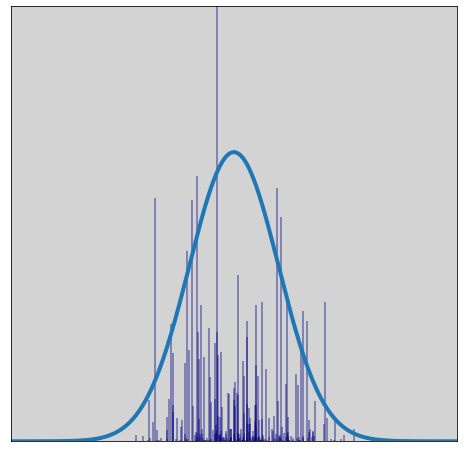

In [47]:
import torch 
import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation

p = torch.distributions.Normal(0, 1)
x = torch.linspace(-5,5, 10000)
pi = torch.distributions.Dirichlet(0.005*torch.ones(10000)).sample()

fig, ax = plt.subplots(1,figsize=(8,8))
ln = plt.vlines(p.sample((10000,)), pi*10, ".", alpha=0.5)
plt.plot(x, p.log_prob(x).exp(), lw=4)
ax.set_facecolor('lightgrey')
plt.xlim(-5,5)
plt.ylim(0, 0.6)
plt.xticks([])
plt.yticks([])
#plt.axis("off")


def update(frame):
    ax.clear()
    pi = torch.distributions.Dirichlet(0.005*torch.ones(10000)).sample()
    ln = plt.vlines(p.sample((10000,)), pi*10, ".", alpha=0.5, color="navy")
    plt.plot(x, p.log_prob(x).exp(), lw=4)
    ax.set_facecolor('lightgrey')
    plt.xticks([])
    plt.yticks([])
    plt.xlim(-5,5)
    plt.ylim(0, 0.6)
    #plt.axis("off")
    return ln,

ani = FuncAnimation(fig, update, frames=5, blit=True, repeat=True)
ani.save("../assets/cover_bnp.gif", dpi=200, fps=1)